<a href="https://colab.research.google.com/github/sruby8/uplift.ai/blob/master/Chart_Uplift_trunk_pelvis_arm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

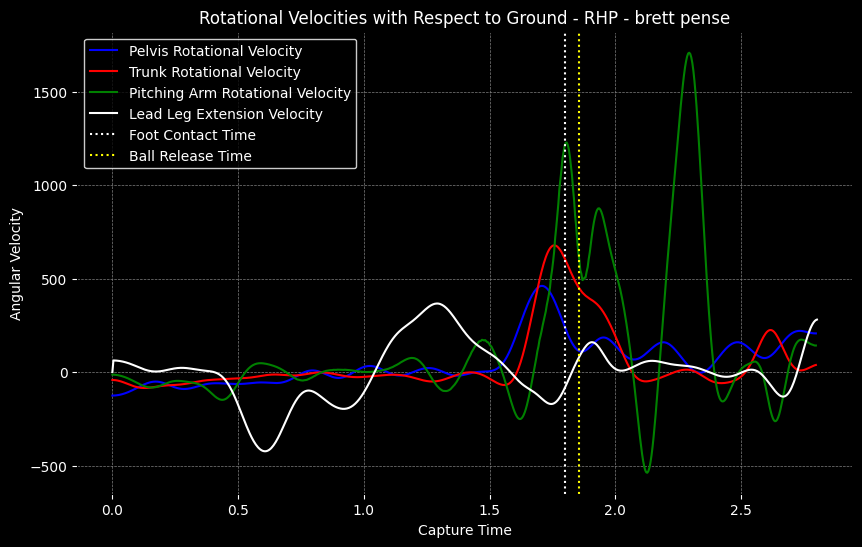

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
file_path = "./uplift_data_export_20250118001337.csv"
data = pd.read_csv(file_path)

# Define column names
athlete_name_col = "athlete_name"
handedness_col = "handedness"
trunk_velocity_col = "trunk_rotational_velocity_with_respect_to_ground"
pelvis_velocity_col = "pelvis_rotational_velocity_with_respect_to_ground"
left_arm_velocity_col = "left_arm_rotational_velocity_with_respect_to_ground"
right_arm_velocity_col = "right_arm_rotational_velocity_with_respect_to_ground"
right_knee_velocity_col = "right_knee_extension_velocity"
left_knee_velocity_col = "left_knee_extension_velocity"
foot_contact_time_col = "foot_contact_time"
ball_release_time_col = "ball_release_time"
time_col = "time"

# Extract athlete name
athlete_name_chart = data[athlete_name_col].iloc[0]

# Determine pitcher handedness
pitcher_handedness = data[handedness_col].iloc[0].lower()
pitcherhand = "LHP" if pitcher_handedness == "left" else "RHP"

# Select appropriate columns based on handedness
if pitcherhand == "LHP":
    arm_velocity_col = left_arm_velocity_col
    lead_leg_velocity_col = right_knee_velocity_col  # Lead leg for left-handers
else:
    arm_velocity_col = right_arm_velocity_col
    lead_leg_velocity_col = left_knee_velocity_col  # Lead leg for right-handers

# Extract the necessary columns
subset_data = data[[handedness_col, arm_velocity_col, time_col, trunk_velocity_col,
                    pelvis_velocity_col, lead_leg_velocity_col, foot_contact_time_col, ball_release_time_col]].copy()

# Rename columns for clarity
subset_data.columns = ["handedness", "arm_velocity", "time", "trunk_velocity",
                       "pelvis_velocity", "lead_leg_extension_velocity", "foot_contact_time", "ball_release_time"]

# Multiply velocity values by -1 if LHP (to normalize rotation direction)
if pitcherhand == "LHP":
    velocity_columns = ["pelvis_velocity", "trunk_velocity", "arm_velocity", "lead_leg_extension_velocity"]
    subset_data[velocity_columns] *= -1

# Locate times for markers safely
foot_contact_time = subset_data.loc[subset_data["foot_contact_time"] == 0.0, "time"]
foot_contact_time = foot_contact_time.min() if not foot_contact_time.empty else None

ball_release_time = subset_data.loc[subset_data["ball_release_time"] == 0.0, "time"]
ball_release_time = ball_release_time.min() if not ball_release_time.empty else None

# Create the chart
plt.figure(figsize=(10, 6), facecolor="black")
ax = plt.gca()
ax.set_facecolor("black")

# Plot rotational velocities
plt.plot(subset_data["time"], subset_data["pelvis_velocity"], color="blue", label="Pelvis Rotational Velocity")
plt.plot(subset_data["time"], subset_data["trunk_velocity"], color="red", label="Trunk Rotational Velocity")
plt.plot(subset_data["time"], subset_data["arm_velocity"], color="green", label="Pitching Arm Rotational Velocity")
plt.plot(subset_data["time"], subset_data["lead_leg_extension_velocity"], color="white", label="Lead Leg Extension Velocity")

# Add vertical markers if they exist
if foot_contact_time is not None:
    plt.axvline(x=foot_contact_time, color="white", linestyle="dotted", label="Foot Contact Time")
if ball_release_time is not None:
    plt.axvline(x=ball_release_time, color="yellow", linestyle="dotted", label="Ball Release Time")

# Customizing the chart for night mode
plt.title(f"Rotational Velocities with Respect to Ground - {pitcherhand} - {athlete_name_chart}", color="white")
plt.xlabel("Capture Time", color="white")
plt.ylabel("Angular Velocity", color="white")
plt.tick_params(colors="white")
plt.legend(facecolor="black", edgecolor="white", labelcolor="white")
plt.grid(color="gray", linestyle="--", linewidth=0.5)

# Show the plot
plt.show()
